In [27]:
import pandas as pd
import numpy as np
import missingno as msno
from scipy import stats

In [28]:
train=pd.read_csv('../data/train.csv')

In [29]:
val=pd.read_csv('../data/val.csv')
test=pd.read_csv('../data/test.csv')

In [30]:
train.head()

,churn,tenure,preferredlogindevice,citytier,warehousetohome,preferredpaymentmode,gender,hourspendonapp,numberofdeviceregistered,preferedordercat,satisfactionscore,maritalstatus,numberofaddress,complain,orderamounthikefromlastyear,couponused,ordercount,daysincelastorder,cashbackamount
0,1,1.0,Phone,2,29.0,E wallet,Male,3.0,4,Mobile,3,Single,3,1,20.0,2.0,2.0,1.0,141.75
1,0,24.0,Phone,1,17.0,COD,Female,2.0,4,Grocery,4,Single,4,0,16.0,0.0,1.0,3.0,231.42
2,0,7.0,Phone,2,34.0,E wallet,Female,3.0,4,Laptop & Accessory,3,Married,2,0,21.0,1.0,1.0,7.0,167.12
3,0,10.0,Phone,1,33.0,Debit Card,Male,4.0,4,Laptop & Accessory,3,Married,8,0,15.0,2.0,2.0,3.0,178.47
4,0,24.0,Phone,1,24.0,Debit Card,Female,3.0,5,Fashion,5,Married,7,0,16.0,2.0,NaN,12.0,257.69


# Handling missing values 

<Axes: >

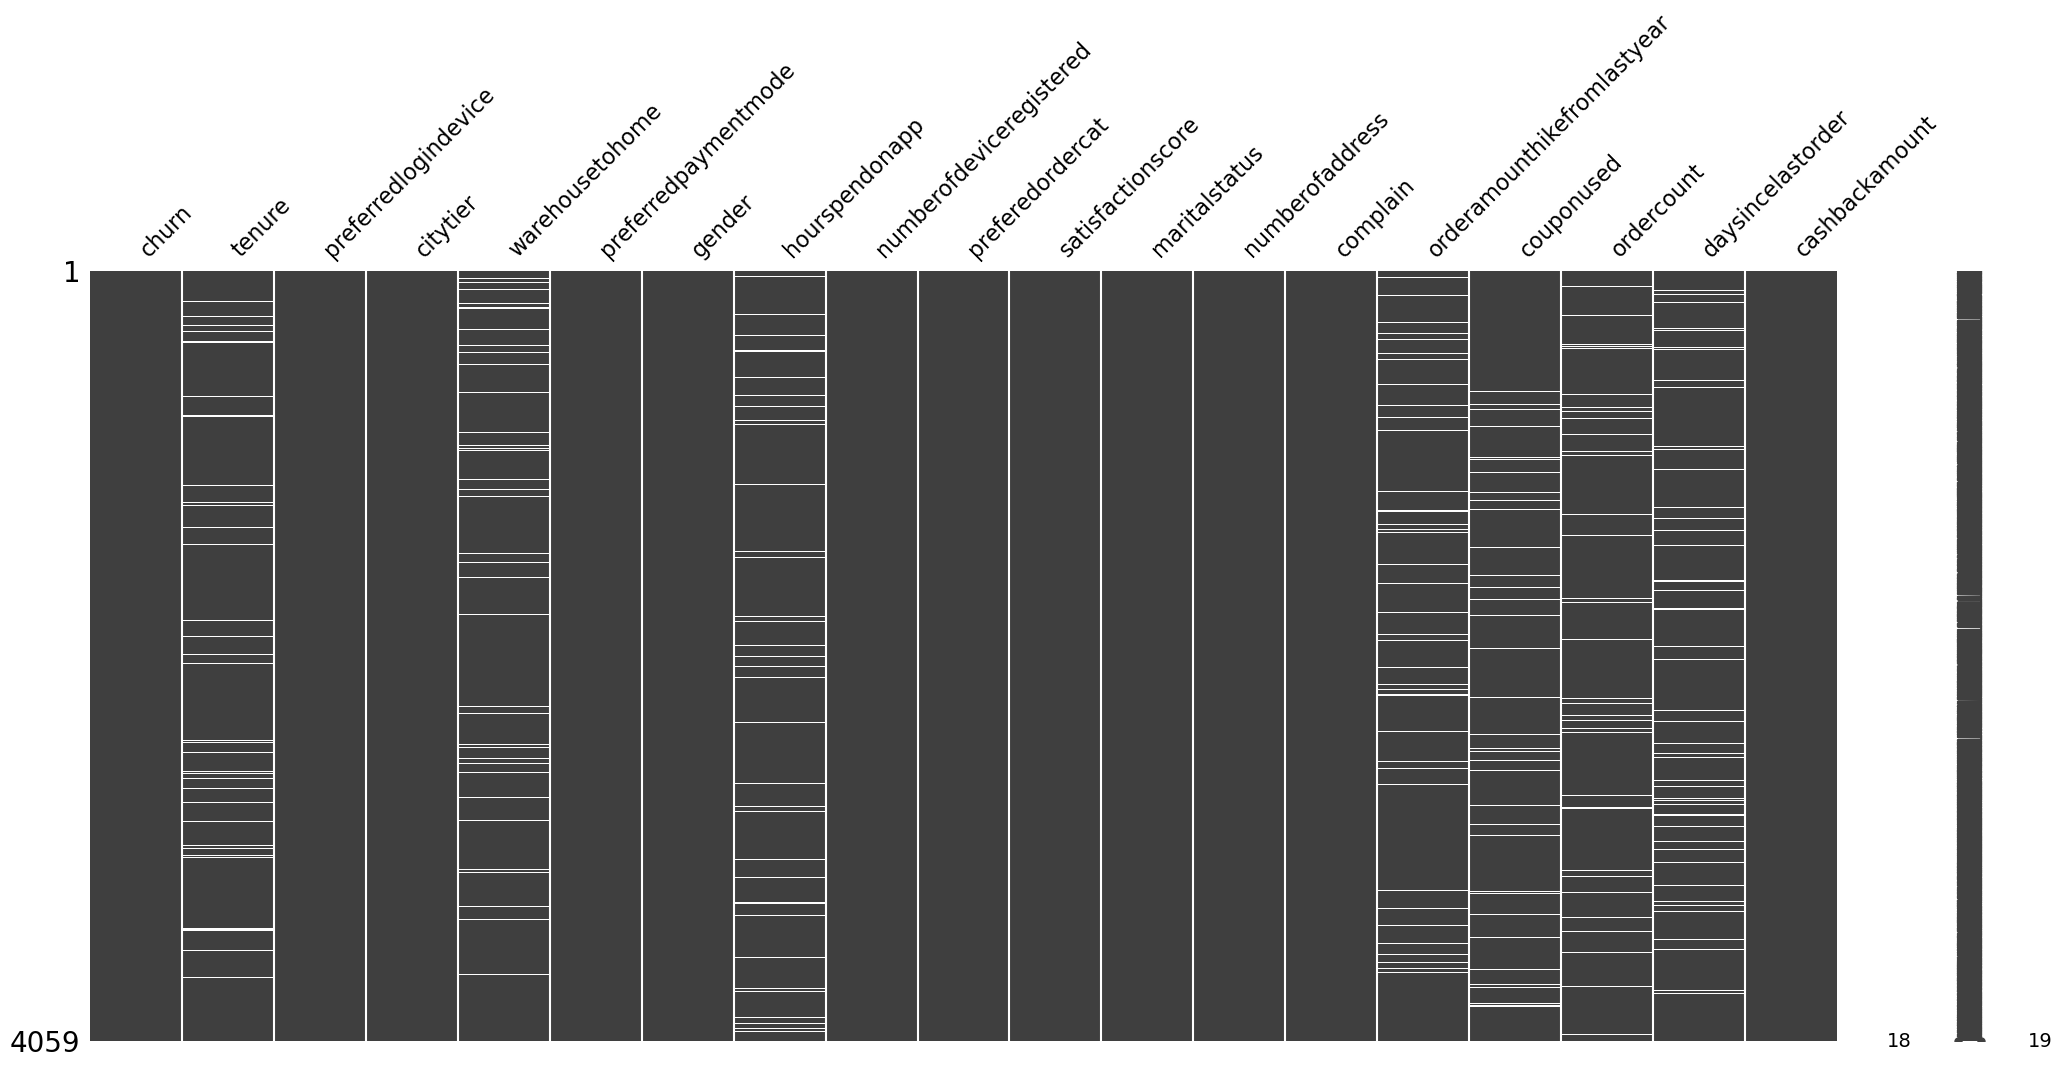

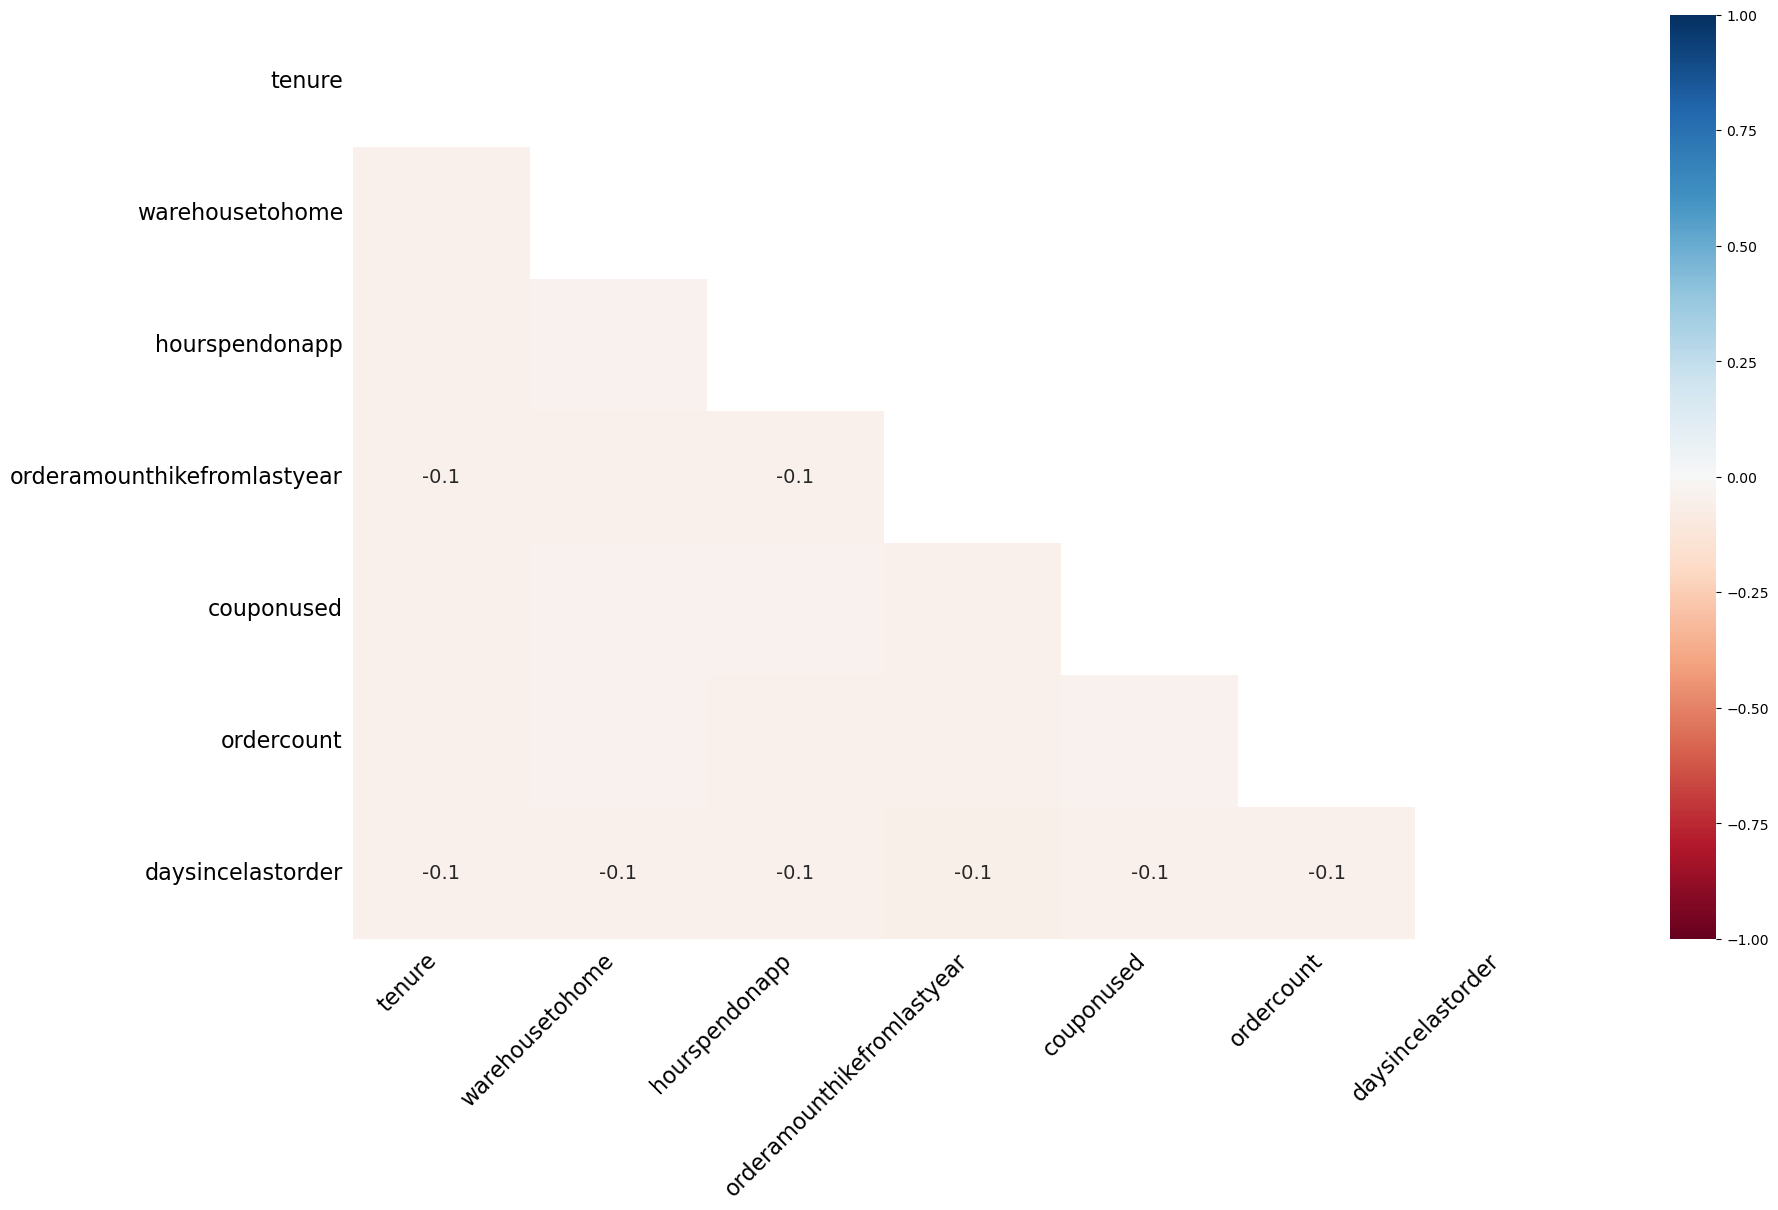

In [32]:


# Plot missing values matrix
msno.matrix(train)

# Plot missing values heatmap
msno.heatmap(train)

## Little MCAR test

In [33]:
def little_mcar_test(data):
    """
    Implementation of Little's MCAR test to determine if data is Missing Completely At Random.
    
    Parameters:
    data (pandas.DataFrame): DataFrame containing missing values
    
    Returns:
    tuple: (test statistic, p-value, degrees of freedom)
    """
    # Ensure we have numeric data only
    data = data.copy()
    
    # Get dimensions and columns
    n = len(data)
    cols = data.columns
    
    # Count observed patterns of missing data
    missing_patterns = data.isnull().astype(int)
    pattern_strings = missing_patterns.apply(lambda x: ''.join(x.astype(str)), axis=1)
    unique_patterns = pattern_strings.unique()
    
    # Calculate overall means for each column (ignoring missing values)
    overall_means = data.mean()
    
    # Initialize variables for the test
    d2 = 0
    df = 0
    
    # For each missing pattern
    for pattern in unique_patterns:
        # Convert pattern string back to binary array
        pattern_array = np.array([int(x) for x in pattern])
        
        # Find rows with this pattern
        pattern_indices = pattern_strings == pattern
        
        # Skip the pattern with all missing values
        if sum(pattern_array) == len(pattern_array):
            continue
        
        # Get columns that are observed in this pattern (not missing)
        observed_cols = [col for i, col in enumerate(cols) if pattern_array[i] == 0]
        
        if len(observed_cols) <= 1:
            continue  # Need at least 2 observed columns for meaningful comparison
        
        # Get observed data for this pattern
        observed_data = data.loc[pattern_indices, observed_cols].dropna()
        
        if len(observed_data) == 0:
            continue
            
        # Number of cases with this pattern
        nj = len(observed_data)
        
        # Calculate component of the test statistic
        # Center the data using overall means (not pattern-specific means)
        obs_data_centered = observed_data - overall_means[observed_cols]
        
        try:
            # Calculate covariance matrix for these columns using all available data
            # We use the numpy cov function which handles missing data better
            obs_data_values = obs_data_centered.values
            
            # Check if we have enough data points
            if len(obs_data_values) <= 1:
                continue
                
            # Calculate covariance matrix directly
            cov_matrix = np.cov(obs_data_values, rowvar=False)
            
            # Ensure the covariance matrix is square and matches the number of columns
            if cov_matrix.shape[0] != len(observed_cols) or cov_matrix.shape[1] != len(observed_cols):
                continue
                
            # Ensure matrix is invertible
            if np.linalg.det(cov_matrix) < 1e-10:
                continue
            
            # Compute the Mahalanobis distance
            inv_cov = np.linalg.inv(cov_matrix)
            
            # Calculate Mahalanobis distance for each row
            maha_distances = []
            for _, row in obs_data_centered.iterrows():
                row_values = row.values.reshape(1, -1)
                maha_d = row_values @ inv_cov @ row_values.T
                maha_distances.append(maha_d[0][0])
            
            # Add to the test statistic
            d2 += sum(maha_distances)
            
            # Add degrees of freedom
            df += nj * len(observed_cols)
            
        except (np.linalg.LinAlgError, ValueError) as e:
            # Skip if covariance matrix is singular or other errors
            continue
    
    # Chi-square test
    if df == 0:
        return 0, 1.0, 0  # No valid patterns found
        
    p_value = 1 - stats.chi2.cdf(d2, df)
    
    return d2, p_value, df

# Example usage
if __name__ == "__main__":
    # Get your DataFrame with only numeric columns
    df_numeric = train.select_dtypes(include=[np.number])
    
    # Run Little's MCAR test
    test_stat, p_value, degrees_freedom = little_mcar_test(df_numeric)
    
    print(f"Little's MCAR Test Results:")
    print(f"Test statistic: {test_stat:.4f}")
    print(f"Degrees of freedom: {degrees_freedom}")
    print(f"p-value: {p_value:.4f}")
    print("\nInterpretation:")
    if p_value < 0.05:
        print("The null hypothesis is rejected. Data is NOT Missing Completely At Random.")
    else:
        print("The null hypothesis cannot be rejected. Data may be Missing Completely At Random.")

Little's MCAR Test Results:
Test statistic: 1015589.7913
Degrees of freedom: 55497
p-value: 0.0000

Interpretation:
The null hypothesis is rejected. Data is NOT Missing Completely At Random.


Since the data seems to missing not at random as even the missing variables are not correlated with each other 
hence we will use KNN imputer or MICE

# One Hot Encode The Features

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
# get all the catergorical columns
cat_cols = train.select_dtypes(include=['object']).columns

In [35]:
cat_cols

Index(['preferredlogindevice', 'preferredpaymentmode', 'gender',
       'preferedordercat', 'maritalstatus'],
      dtype='object')

In [36]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first')

# Fit the encoder on train data
encoder.fit(train[cat_cols])

# Transform all datasets
train_cat_encoded = encoder.transform(train[cat_cols])
val_cat_encoded = encoder.transform(val[cat_cols])
test_cat_encoded = encoder.transform(test[cat_cols])

# Convert to DataFrame with proper column names
feature_names = encoder.get_feature_names_out(cat_cols)
train_cat_df = pd.DataFrame(train_cat_encoded, columns=feature_names, index=train.index)
val_cat_df = pd.DataFrame(val_cat_encoded, columns=feature_names, index=val.index)
test_cat_df = pd.DataFrame(test_cat_encoded, columns=feature_names, index=test.index)

# Drop original categorical columns and concatenate encoded features
train_encoded = pd.concat([train.drop(cat_cols, axis=1), train_cat_df], axis=1)
val_encoded = pd.concat([val.drop(cat_cols, axis=1), val_cat_df], axis=1)
test_encoded = pd.concat([test.drop(cat_cols, axis=1), test_cat_df], axis=1)

In [38]:
from sklearn.impute import KNNImputer

# Initialize KNN Imputer with k=3
imputer = KNNImputer(n_neighbors=3)

# Apply imputation on numeric columns
train_imputed = pd.DataFrame(imputer.fit_transform(train_encoded), columns=train_encoded.columns)

# Check if there are any remaining missing values
print("Number of missing values after imputation:")
print(train_imputed.isnull().sum())

# Compare a few statistics before and after imputation
print("\nComparing statistics before and after imputation:")
print("\nBefore imputation:")
print(train_encoded.describe().round(2))
print("\nAfter imputation:")
print(train_imputed.describe().round(2))

Number of missing values after imputation:
churn                                  0
tenure                                 0
citytier                               0
warehousetohome                        0
hourspendonapp                         0
numberofdeviceregistered               0
satisfactionscore                      0
numberofaddress                        0
complain                               0
orderamounthikefromlastyear            0
couponused                             0
ordercount                             0
daysincelastorder                      0
cashbackamount                         0
preferredlogindevice_Phone             0
preferredpaymentmode_COD               0
preferredpaymentmode_Debit Card        0
preferredpaymentmode_E wallet          0
preferredpaymentmode_UPI               0
gender_Male                            0
preferedordercat_Grocery               0
preferedordercat_Laptop & Accessory    0
preferedordercat_Mobile                0
preferedorderc

In [39]:
# Transform validation and test sets using the fitted imputer
val_imputed = pd.DataFrame(imputer.transform(val_encoded), columns=val_encoded.columns)
test_imputed = pd.DataFrame(imputer.transform(test_encoded), columns=test_encoded.columns)

# Check if there are any remaining missing values
print("Number of missing values in validation set after imputation:")
print(val_imputed.isnull().sum())

print("\nNumber of missing values in test set after imputation:")
print(test_imputed.isnull().sum())

Number of missing values in validation set after imputation:
churn                                  0
tenure                                 0
citytier                               0
warehousetohome                        0
hourspendonapp                         0
numberofdeviceregistered               0
satisfactionscore                      0
numberofaddress                        0
complain                               0
orderamounthikefromlastyear            0
couponused                             0
ordercount                             0
daysincelastorder                      0
cashbackamount                         0
preferredlogindevice_Phone             0
preferredpaymentmode_COD               0
preferredpaymentmode_Debit Card        0
preferredpaymentmode_E wallet          0
preferredpaymentmode_UPI               0
gender_Male                            0
preferedordercat_Grocery               0
preferedordercat_Laptop & Accessory    0
preferedordercat_Mobile              

## Feature Engineering 

In [40]:
train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4059 entries, 0 to 4058
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   churn                                4059 non-null   float64
 1   tenure                               4059 non-null   float64
 2   citytier                             4059 non-null   float64
 3   warehousetohome                      4059 non-null   float64
 4   hourspendonapp                       4059 non-null   float64
 5   numberofdeviceregistered             4059 non-null   float64
 6   satisfactionscore                    4059 non-null   float64
 7   numberofaddress                      4059 non-null   float64
 8   complain                             4059 non-null   float64
 9   orderamounthikefromlastyear          4059 non-null   float64
 10  couponused                           4059 non-null   float64
 11  ordercount                    

In [41]:
train_imputed.to_csv('../data/train_no_missing_encoded.csv',index=False)
val_imputed.to_csv('../data/val_no_missing_encoded.csv',index=False)
test_imputed.to_csv('../data/test_no_missing_encoded.csv',index=False)

## Outliers

In [43]:
from sklearn.ensemble import IsolationForest

# Fit the model
iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination as needed
outliers = iso_forest.fit_predict(train_imputed)

# Identify outliers (outliers are labeled as -1)
outlier_indices = np.where(outliers == -1)[0]
train_imputed.iloc[outlier_indices]

,churn,tenure,citytier,warehousetohome,hourspendonapp,numberofdeviceregistered,satisfactionscore,numberofaddress,complain,orderamounthikefromlastyear,...,preferredpaymentmode_COD,preferredpaymentmode_Debit Card,preferredpaymentmode_E wallet,preferredpaymentmode_UPI,gender_Male,preferedordercat_Grocery,preferedordercat_Laptop & Accessory,preferedordercat_Mobile,preferedordercat_Others,maritalstatus_Single
40,0.0,17.000000,2.0,23.0,4.0,4.0,2.0,7.0,1.0,23.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
49,0.0,25.000000,1.0,13.0,3.0,4.0,3.0,9.0,0.0,21.666667,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
51,0.0,28.000000,2.0,32.0,2.0,4.0,1.0,2.0,0.0,14.333333,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
80,0.0,9.000000,2.0,21.0,2.0,5.0,1.0,2.0,0.0,24.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
85,1.0,9.333333,1.0,10.0,2.0,3.0,1.0,10.0,1.0,23.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,1.0,1.000000,2.0,7.0,4.0,6.0,5.0,2.0,0.0,22.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3931,1.0,5.000000,2.0,18.0,2.0,3.0,5.0,1.0,1.0,12.000000,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3975,1.0,11.000000,2.0,16.0,3.0,6.0,3.0,9.0,0.0,12.000000,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3988,0.0,16.000000,2.0,22.0,3.0,3.0,2.0,6.0,1.0,22.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# PCA on train_imputed

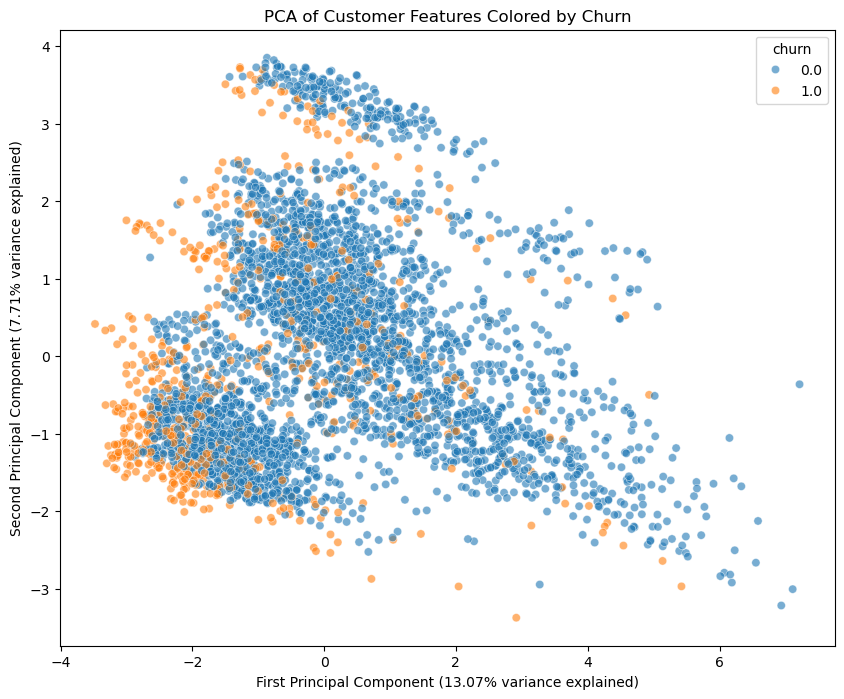

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

import matplotlib.pyplot as plt

# Create scaler and fit on training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_imputed)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['churn'] = train_imputed['churn']

# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='churn', alpha=0.6)
plt.title('PCA of Customer Features Colored by Churn')

# Add variance explained information
var_explained = pca.explained_variance_ratio_
plt.xlabel(f'First Principal Component ({var_explained[0]:.2%} variance explained)')
plt.ylabel(f'Second Principal Component ({var_explained[1]:.2%} variance explained)')

plt.show()